# Lab Assignment 2 Scientific Computing

Nick Boon & Marleen Rijksen

In [61]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import animation,rc

from IPython.display import HTML
rc('animation',html='html5')

from numba import jit
from itertools import compress

%matplotlib inline

### K. Implementation of Diffusion Limited Aggregation (DLA)

In [114]:
@jit
def diff_timestep_sor_img(cur, epsilon, omega, obj_dict):
    """
    Performs a single timestep of the diffusion equation for
    Successive Over Relaxation method
    """
    N = cur.shape[0]
    conv_bool = True 
            
    # iterate over the domain
    for y in range(1,N-1):
        for x in range(0,N):
            prev = cur[y,x]
            left = x-1 if not x==0 else N-1
            right = x+1 if not x==N-1 else 0
            
            if ((y,x), True) in obj_dict.items():
                cur[y,x] = 0
            else:
                cur[y,x] = omega/4 * (cur[y-1,x]+cur[y+1,x]+cur[y,right]+cur[y,left])\
                       + (1-omega) * cur[y,x]
            
            # convergence condition
            if abs(prev-cur[y,x]) > epsilon:
                conv_bool = False  
    return cur, conv_bool


def sor(cur, epsilon, omega, image):
    """
    Performs successive over relaxation until convergence
    """
    
    conv_bool = False
    i = 0
    while not conv_bool:
        cur, conv_bool = diff_timestep_sor_img(cur, epsilon, omega, image)
        i += 1
    return cur, i

In [146]:
def update_obj_dict(cur,obj_dict,add_object):
    """
    Update neighbour dictionary and sets concentration to zero
    
    Assumes origin at upper-left
    
    Input:
    shape (y,x) shape of space
    obj_dict    dictionary containing (y,x)-tuples
                True: part of object
                False: neighbour of object
    add_object (y,x)   location of newly added part of object
    
    Output:
    obj_dict    updated dictionary of object and candidate locations
                in (y,x)-tuples
    """
    
    shape = cur.shape
    y,x = add_object
    
    #add to object --> True
    obj_dict[add_object] = True
    cur[add_object] = 0
    
    #set potential --> False
    
    #left
    if (y,x-1 if x > 0 else shape[1]-1) not in obj_dict:
        obj_dict[(y,x-1 if x > 0 else shape[1]-1)] = False
    #right
    if (y,x+1 if x < shape[1]-1 else 0) not in obj_dict:
        obj_dict[(y,x+1 if x < shape[1]-1 else 0)] = False
    #down (actually up with origin upper-left)
    if y-1 != 0 and (y-1,x) not in obj_dict:
        obj_dict[(y-1,x)] = False
    #up (actually down with origin upper-left)
    if y+1 != shape[0]-1 and (y+1,x) not in obj_dict:
        obj_dict[(y+1,x)] = False
    
    #return updated dict
    return cur, obj_dict

def DLA(cur,obj_dict,steps,epsilon,eta):
    
    for i in range(steps):
        #diffusion step
        cur,_ = sor(cur, epsilon, 1.92, obj_dict)
        
        #grow object
        candidate_sites = [k for k,v in obj_dict.items() if v == False]
        c_list = np.zeros(len(candidate_sites))
        
        for i,loc in enumerate(candidate_sites):
            #get concentration at candidates
            y,x = loc
            c_list[i] = cur[y,x] ** eta
        
        c_list = c_list / np.sum(c_list)
        
        rand = np.random.random(len(c_list))
        
        grow_list = c_list > rand
        
        for loc in list(compress(candidate_sites, grow_list)):
            cur, obj_dict = update_obj_dict(cur,obj_dict,loc)
            
    return cur, obj_dict
        
def generate_initial(shape,obj_loc,boundary_cond):
    """
    Generate initial concentration and object arrays
    
    Assume origin at upper-left of matrix
    
    Input:
    shape (y,x)
    obj_loc (y,x)
    boundary_cond (y=0, y=ymax)
    
    Output:
    box [xmin, xmax, ymin, ymax]
    """
    
    #init concentration array
    cur = np.zeros(shape)
    cur[0,:], cur[cur.shape[0]-1,:] = boundary_cond
    
    #cannot init object on boundary
    assert obj_loc[0] not in (0,shape[0]-1), "cannot start at y-boundary"
    cur[obj_loc] = 5

    cur,obj_dict = update_obj_dict(cur,{},obj_loc)
    
    return cur,obj_dict

def show_object(cur,obj_dict,figsize=(10,8)):
    """
    Generates figure, showing the concentration with the object
    and candidate sites. Returns the figure and axes used.
    """
    
    #init figure, axes
    fig,ax = plt.subplots(figsize=figsize)
    
    #plot concentration and colorbar
    cb = ax.imshow(cur,origin='lower')
    plt.colorbar(cb)
    
    #plot the object and candidate sites
    #reduce size of marker for when more space is shown
    size = 20#
    #iterate over locations
    for k,v in obj_dict.items():
        y,x = k
        if v: #object -> True
            ax.scatter(x,y,s=size, facecolors='k', edgecolors='k')
        elif not v: #candidate -> False
            ax.scatter(x,y,s=size, facecolors='none', edgecolors='k')
    return fig,ax

Object at: [(3, 3)]
Candidates at: [(3, 2), (3, 4), (2, 3), (4, 3)]


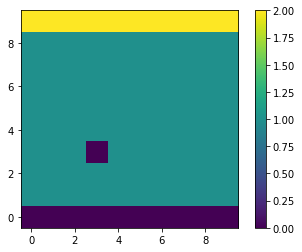

In [141]:
#Generate the concentration array and object dictionary with these parameters:
#Size: 10x10
#Object starts at (y,x) = (3,3)
#Boundaries at (0,ymax) = (1,2)
cur, obj_dict = generate_initial((10,10),(3,3),(0,2))

#show generated initial state
fig,ax = plt.subplots()
cb = ax.imshow(cur,origin='lower') #this transforms the matrix such that the origin moves from upper-left to lower-left
plt.colorbar(cb)

print("Object at: %s"%[k for k,v in obj_dict.items() if v == True])
print("Candidates at: %s"%[k for k,v in obj_dict.items() if v == False])

C:\Users\Nick\Miniconda3\envs\ml1labs\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Nick\Miniconda3\envs\ml1labs\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater


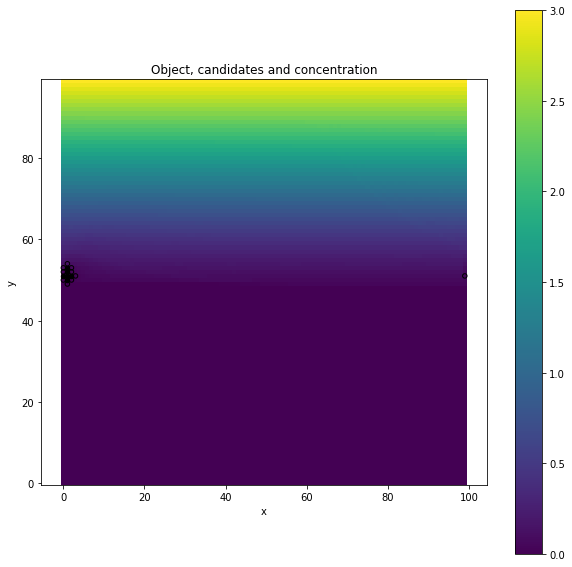

In [185]:
cur, obj_dict = generate_initial((100,100),(1,50),(0,3))
cur, obj_dict = DLA(cur,obj_dict,50,0.00001,2)
fig,ax = show_object(cur,obj_dict,(10,10))
ax.set_title("Object, candidates and concentration")
ax.set_xlabel("x")
ax.set_ylabel("y");

Text(0,0.5,'y')

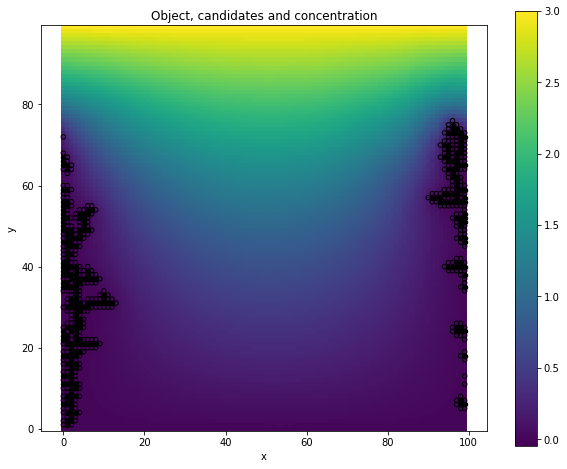

In [182]:
fig,ax = show_object(cur,obj_dict)
ax.set_title("Object, candidates and concentration")
ax.set_xlabel("x")
ax.set_ylabel("y")